In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd
print(pd.__version__)

1.2.4


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
# from finrl.env.env_stocktrading_v2 import StockTradingEnvV2
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_plot, backtest_stats

from pprint import pprint




/DATA/jimson/.local/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [8]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [10]:
processed['log_volume'] = np.log(processed.volume*processed.close)
processed['change'] = (processed.close-processed.open)/processed.close
processed['daily_variance'] = (processed.high-processed.low)/processed.close
processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence,log_volume,change,daily_variance
0,2008-12-31,3.070357,3.133571,3.047857,2.621168,607541200,AAPL,2,0.0,100.0,66.666667,100.0,0.0,21.188551,-0.171370,0.032701
1,2008-12-31,17.969999,18.750000,17.910000,15.025569,9625600,AXP,2,0.0,100.0,66.666667,100.0,0.0,18.789690,-0.195961,0.055905
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,0.0,100.0,66.666667,100.0,0.0,18.975780,-0.299448,0.048429
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2,0.0,100.0,66.666667,100.0,0.0,19.094891,-0.397833,0.044782
4,2008-12-31,16.180000,16.549999,16.120001,12.019092,37513700,CSCO,2,0.0,100.0,66.666667,100.0,0.0,19.926713,-0.346192,0.035776


In [11]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

75480
15150


In [12]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
from copy import deepcopy

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
import random

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger
import time


class StockTradingEnvV2(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        transaction_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        turbulence_threshold=None,
        print_verbosity=10,
        reward_scaling=1e-4,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        out_of_cash_penalty=None,
        cache_indicator_data=True,
        daily_reward=None,
        cash_penalty_proportion=0.1,
        random_start=True,
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start

        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        if out_of_cash_penalty is None:
            out_of_cash_penalty = -initial_amount * 0.5
        self.out_of_cash_penalty = out_of_cash_penalty
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.daily_reward = daily_reward
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [
                self.get_date_vector(i) for i, _ in enumerate(self.dates)
            ]
            print("data cached!")

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)

    @property
    def current_step(self):
        return self.date_index - self.starting_point

    def reset(self):
        self.seed()
        self.sum_trades = 0
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            "reward": [],
        }
        init_state = np.array(
            [self.initial_amount]
            + [0] * len(self.assets)
            + self.get_date_vector(self.date_index)
        )
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v

    def return_terminal(self, reason="Last Date", reward=0):

        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        reward = reward * self.reward_scaling
        # Add outputs to logger interface
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        logger.record("environment/total_reward_pct", (reward_pct - 1) * 100)
        logger.record(
            "environment/daily_trades",
            self.sum_trades / (self.current_step) / len(self.assets),
        )
        logger.record("environment/completed_steps", self.current_step)
        logger.record(
            "environment/sum_rewards", np.sum(self.account_information["reward"])
        )
        logger.record(
            "environment/cash_proportion",
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1],
        )
        return state, reward, True, {}

    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1]
        )
        rec = [
            self.episode,
            self.date_index - self.starting_point,
            reason,
            f"${int(self.account_information['total_assets'][-1])}",
            f"{terminal_reward*100:0.5f}%",
            f"{cash_pct*100:0.2f}%",
        ]

        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def log_header(self):
        self.template = "{0:4}|{1:4}|{2:15}|{3:10}|{4:10}|{5:10}"  # column widths: 8, 10, 15, 7, 10
        print(
            self.template.format(
                "EPISODE",
                "STEPS",
                "TERMINAL_REASON",
                "TOT_ASSETS",
                "TERMINAL_REWARD_unsc",
                "CASH_PCT",
            )
        )
        self.printed_header = True
        
    def get_reward(self):
        if self.current_step==0:
            return 0
        else:
            assets = self.account_information['total_assets'][-1]
            cash = self.account_information['cash'][-1]
            cash_penalty = max(0, (assets*self.cash_penalty_proportion-cash))
            assets -= cash_penalty
            reward = (assets/self.initial_amount)-1
            reward/=self.current_step
            return reward

    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step.
        self.sum_trades += np.sum(np.abs(actions))

        # print header only first time
        if self.printed_header is False:
            self.log_header()

        # print if it's time.
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")

        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            # compute value of cash + assets
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert min(holdings) >= 0
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))
            asset_value = np.dot(holdings, closings)

            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            reward = self.get_reward()

            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information["reward"].append(reward)

            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions)

            # scale cash purchases to asset # changes
            actions = actions / closings
            self.transaction_memory.append(actions)

            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))

            # compute our proceeds from sales, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.transaction_cost_pct
            coh = begin_cash + proceeds

            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.transaction_cost_pct

            # if we run out of cash, end the cycle and penalize
            if (spend + costs) > coh:
                return self.return_terminal(
                    reason="CASH SHORTAGE",
                    reward=self.get_reward()
                )

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions
            self.date_index += 1
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            reward = reward * self.reward_scaling
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)

        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs

    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)

        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[
                -len(self.account_information["cash"]) :
            ]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame(
                {
                    "date": self.dates[-len(self.account_information["cash"]) :],
                    "actions": self.actions_memory,
                    "transactions": self.transaction_memory,
                }
            )


In [13]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence,log_volume,change,daily_variance
0,2008-12-31,3.070357,3.133571,3.047857,2.621168,607541200,AAPL,2,0.0,100.0,66.666667,100.0,0.0,21.188551,-0.171370,0.032701
1,2008-12-31,17.969999,18.750000,17.910000,15.025569,9625600,AXP,2,0.0,100.0,66.666667,100.0,0.0,18.789690,-0.195961,0.055905
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,0.0,100.0,66.666667,100.0,0.0,18.975780,-0.299448,0.048429
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2,0.0,100.0,66.666667,100.0,0.0,19.094891,-0.397833,0.044782
4,2008-12-31,16.180000,16.549999,16.120001,12.019092,37513700,CSCO,2,0.0,100.0,66.666667,100.0,0.0,19.926713,-0.346192,0.035776


In [14]:
information_cols = ['daily_variance', 'change', 'log_volume', 'close','day', 
                    'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

e_train_gym = StockTradingEnvV2(df = train,initial_amount = 1e6,hmax = 5000, 
                                out_of_cash_penalty = 0, 
                                cache_indicator_data=True,
                                cash_penalty_proportion=0.2, 
                                reward_scaling=1,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, random_start = True)


trade = data_split(processed, '2019-01-01','2021-01-01')


e_trade_gym = StockTradingEnvV2(df = trade,initial_amount = 1e6,hmax = 5000, 
                                out_of_cash_penalty = 0, 
                                cash_penalty_proportion=0.2,
                                reward_scaling = 1, 
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, random_start = False)



caching data
data cached!
caching data
data cached!


In [15]:
# for this example, let's do multiprocessing with n_cores-2

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 1 # Over-ride
print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()


#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()


using 1 cores
EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   1| 107|CASH SHORTAGE  |$925586   |-0.17967% |7.27%     
   2|  12|CASH SHORTAGE  |$1006500  |-1.31400% |3.69%     
   3|  12|CASH SHORTAGE  |$976972   |-1.51085% |3.80%     
   4|  12|CASH SHORTAGE  |$1015172  |-1.25618% |3.66%     
   5|  12|CASH SHORTAGE  |$1033413  |-1.13458% |3.59%     
   6|  12|CASH SHORTAGE  |$993569   |-1.40020% |3.74%     
   7|  12|CASH SHORTAGE  |$996848   |-1.37834% |3.72%     
   8|  12|CASH SHORTAGE  |$998091   |-1.37006% |3.72%     
   9|  12|CASH SHORTAGE  |$1005539  |-1.32040% |3.69%     
  10|  12|CASH SHORTAGE  |$1027233  |-1.17577% |3.61%     
  11|  12|CASH SHORTAGE  |$974586   |-1.52676% |3.81%     
  12|  12|CASH SHORTAGE  |$956643   |-1.64638% |3.88%     
  13|  12|CASH SHORTAGE  |$1008573  |-1.30018% |3.68%     
  14|  12|CASH SHORTAGE  |$996817   |-1.37855% |3.72%     
  15|  12|CASH SHORTAGE  |$997749   |-1.37234% |3.72%     
  16|  12|CASH SHORTAGE  |$9

 277|  12|CASH SHORTAGE  |$995269   |-1.38887% |3.73%     
 278|  12|CASH SHORTAGE  |$1000681  |-1.35279% |3.71%     
 279|  12|CASH SHORTAGE  |$986081   |-1.45013% |3.76%     
 280|  12|CASH SHORTAGE  |$1002418  |-1.34121% |3.70%     
 281|  12|CASH SHORTAGE  |$1004192  |-1.32939% |3.70%     
 282|  12|CASH SHORTAGE  |$1001247  |-1.34902% |3.71%     
 283|  12|CASH SHORTAGE  |$1050151  |-1.02299% |3.53%     
 284|  12|CASH SHORTAGE  |$1020938  |-1.21774% |3.64%     
 285|  12|CASH SHORTAGE  |$1004560  |-1.32693% |3.70%     
 286|  12|CASH SHORTAGE  |$1014834  |-1.25843% |3.66%     
 287|  12|CASH SHORTAGE  |$1020221  |-1.22253% |3.64%     
 288|  12|CASH SHORTAGE  |$977935   |-1.50443% |3.80%     
 289|  12|CASH SHORTAGE  |$992194   |-1.40937% |3.74%     
 290|  12|CASH SHORTAGE  |$980862   |-1.48492% |3.78%     
 291|  12|CASH SHORTAGE  |$1004870  |-1.32486% |3.69%     
 292|  12|CASH SHORTAGE  |$1002912  |-1.33791% |3.70%     
 293|  12|CASH SHORTAGE  |$1037363  |-1.10824% |3.58%   

In [16]:
agent = DRLAgent(env = env_train)

In [18]:
model = agent.get_model("ddpg", verbose = 0)

# model = model.load("scaling_reward.model", env = env_train)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}


In [29]:
model.learn(total_timesteps = 5000, 
            eval_env = env_trade, 
            eval_freq = 250,
            log_interval = 1, 
            tb_log_name = '1_18_lastrun',
            n_eval_episodes = 1)

/DATA/jimson/.local/lib/python3.8/site-packages/stable_baselines3/common/callbacks.py:327: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d143c220> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d143cb50>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/DATA/jimson/.local/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  17|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=250, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
New best mean reward!
  19|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=500, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
  21|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=750, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
  23|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=1000, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
  25|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=1250, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
  27|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=1500, episode_reward=-0.00 +/- 0.00
Episode length: 13.00 +/- 0.00
  29|  12|CASH SHORTAGE  |$1027551  |-1.17366% |3.61%     
Eval num_timesteps=1750, episode_reward=-0.00 +/- 0.

In [30]:
model.save("DDPG.model")

In [31]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [32]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.287782
std        33.993912
min         0.000000
25%        15.240539
50%        25.166989
75%        39.290071
max       332.849743
Name: turbulence, dtype: float64

In [33]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [34]:
print(turbulence_threshold)

332.8497428482094


In [35]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence,log_volume,change,daily_variance
0,2019-01-02,38.722500,39.712502,38.557499,38.439735,148158800,AAPL,2,-2.013469,37.867359,-91.575723,42.250808,51.408926,22.462887,-0.007356,0.030047
0,2019-01-02,93.910004,96.269997,93.769997,91.803406,4175400,AXP,2,-3.394947,41.204996,-97.765841,26.709417,51.408926,19.764370,-0.022947,0.027232
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200,BA,2,-5.550592,47.010000,-21.712382,13.611972,51.408926,20.758512,-0.004910,0.032545
0,2019-01-02,124.029999,127.879997,123.000000,118.137177,4783200,CAT,2,-0.680049,48.229091,-5.147002,0.873482,51.408926,20.152467,-0.049881,0.041308
0,2019-01-02,42.279999,43.200001,42.209999,39.496738,23833500,CSCO,2,-0.939011,44.872565,-87.556999,29.529377,51.408926,20.662821,-0.070468,0.025065


In [42]:

e_trade_gym.hmax = 100





In [43]:
print(len(e_trade_gym.dates))

505


In [44]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   1| 499|update         |$1108580  |0.01881%  |18.11%    
   1| 504|Last Date      |$1122532  |0.01802%  |17.17%    
hit end!


In [45]:
df_account_value.shape

(504, 5)

In [46]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.0,0.000000,1.000000e+06,0.000000,2019-01-03
1,998395.2,1560.325011,9.999555e+05,0.000000,2019-01-04
2,996790.4,3267.602987,1.000058e+06,-0.000022,2019-01-07
3,995185.6,4877.692870,1.000063e+06,0.000019,2019-01-08
4,993580.8,6549.272659,1.000130e+06,0.000016,2019-01-09
5,991976.0,8167.885701,1.000144e+06,0.000026,2019-01-10
6,990371.2,9818.216648,1.000189e+06,0.000024,2019-01-11
7,988766.4,11417.264184,1.000184e+06,0.000027,2019-01-14
8,987161.6,12936.637434,1.000098e+06,0.000023,2019-01-15
9,985556.8,14650.490200,1.000207e+06,0.000011,2019-01-16


In [47]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')

==============Get Backtest Results===========
Annual return          0.059496
Cumulative returns     0.122532
Annual volatility      0.124157
Sharpe ratio           0.528636
Calmar ratio           0.361963
Stability              0.166311
Max drawdown          -0.164371
Omega ratio            1.130062
Sortino ratio          0.732067
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003002
Daily value at risk   -0.015382
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-03
End date,2020-12-31
Total months,24
,Backtest
Annual return,5.95%
Cumulative returns,12.253%
Annual volatility,12.416%
Sharpe ratio,0.53
Calmar ratio,0.36
Stability,0.17
Max drawdown,-16.437%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.44,2020-02-13,2020-03-24,2020-08-13,131
1,6.06,2020-09-03,2020-10-29,2020-11-10,49
2,2.32,2020-11-17,2020-11-23,2020-12-03,13
3,1.69,2020-01-21,2020-02-03,2020-02-06,13
4,1.61,2019-07-16,2019-08-16,2019-11-08,84


/DATA/jimson/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/DATA/jimson/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/DATA/jimson/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/DATA/jimson/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationW

Stress Events,mean,min,max
New Normal,0.03%,-5.01%,4.06%


/DATA/jimson/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


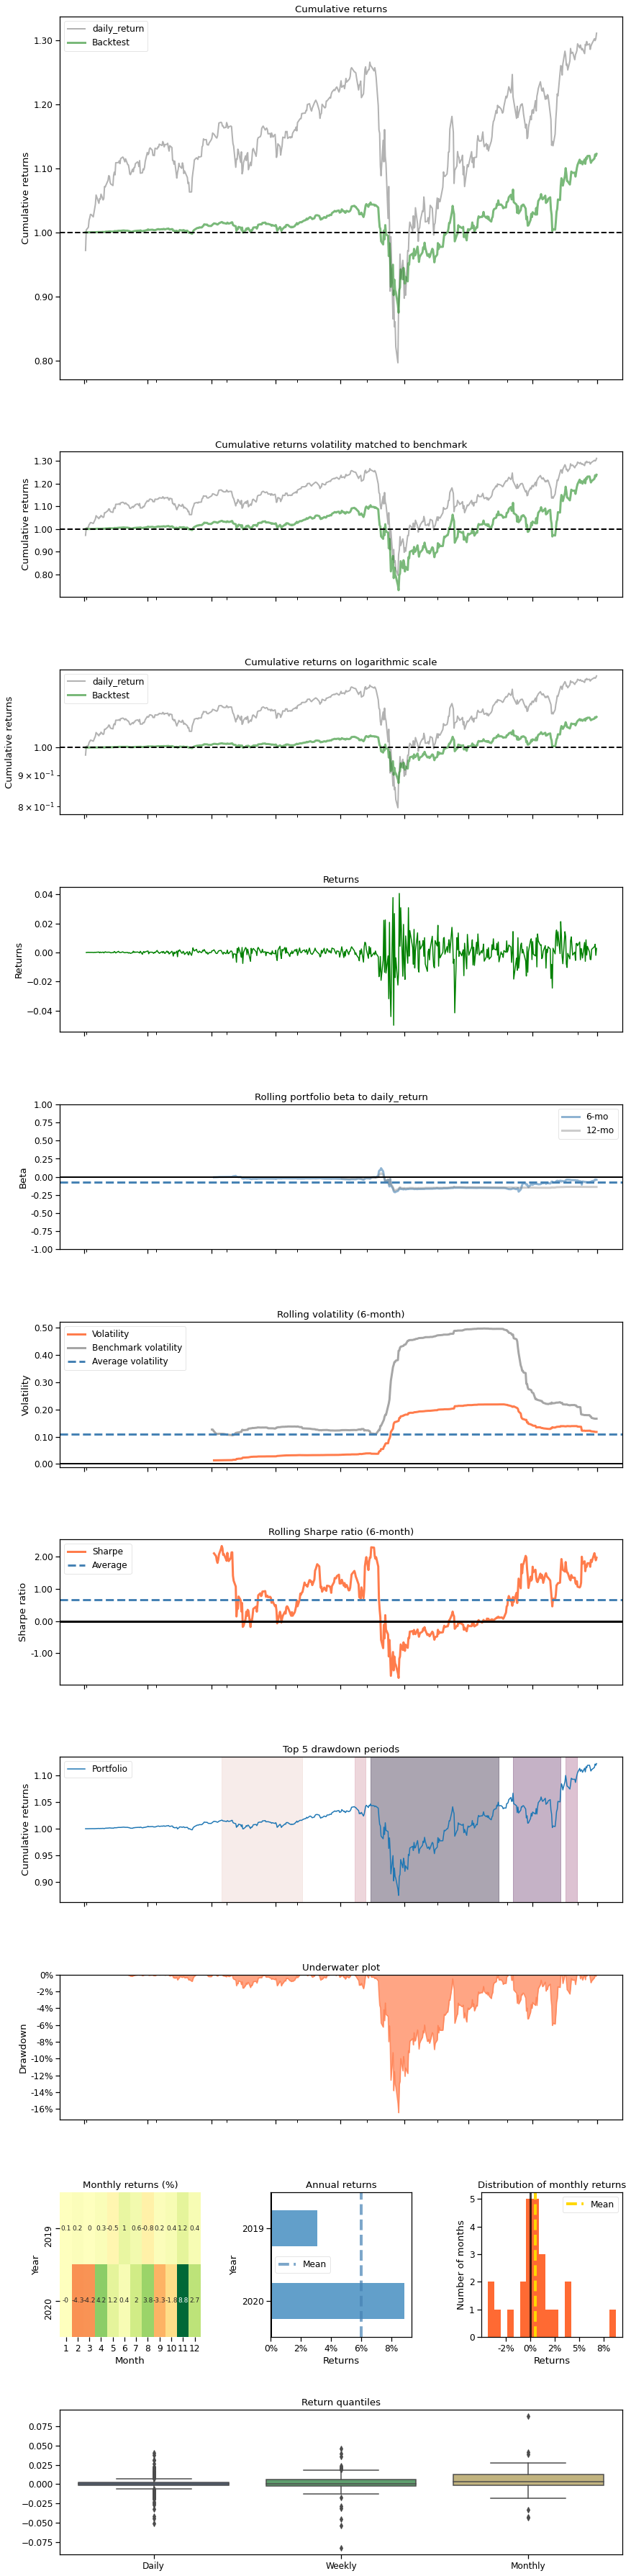

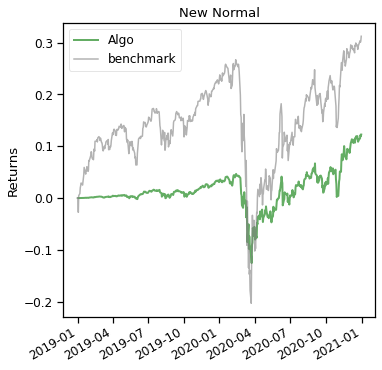

In [48]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')